In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
howell_data = pd.read_csv("../data/Howell1.csv", sep=";")
howell_data.rename(columns={"male": "sex"}, inplace=True)
howell_data.head()

,height,weight,age,sex
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


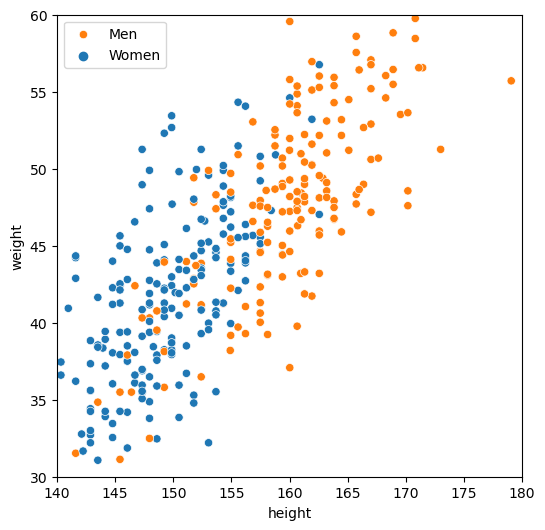

In [33]:
plt.figure(figsize=(6, 6))

sns.scatterplot(howell_data, x="height", y='weight', hue="sex")
plt.xlim(140, 180)
plt.ylim(30, 60)
plt.legend(labels=["Men", "Women"])
plt.show()

<img src="images/image7.jpeg" width="600" height="400" />

In [34]:
howell_trace = pd.read_csv("../data/howell1_trace.csv")
howell_trace.head()

,chain,draw,a,b,sigma
0,0,0,-32.931044,0.496165,4.996256
1,0,1,-32.902922,0.495551,4.989297
2,0,2,-32.415731,0.492640,5.186679
3,0,3,-33.127071,0.498403,5.265602
4,0,4,-33.207031,0.497945,5.250224


In [35]:
pd.DataFrame({"sex": [0, 1, 0, 1], "age": range(4)})

,sex,age
0,0,0
1,1,1
2,0,2
3,1,3


In [36]:
import numpy as np
import pandas as pd

def sim_HW(sex, b, a):
    """
    Simulate heights and weights based on sex using linear regression parameters.

    Parameters:
    sex (array-like): An array indicating the sex of individuals (1 for female, 2 for male).
    b (array-like): An array containing the slope parameters for each sex.
    a (array-like): An array containing the intercept parameters for each sex.

    Returns:
    pd.DataFrame: A DataFrame containing the simulated data for sex, height, and weight.
    """
    N = len(sex)  # Number of individuals
    
    # Simulate heights H
    # Heights are centered around 150 cm for females (sex = 1) and 160 cm for males (sex = 2)
    # with added normal noise (mean 0, standard deviation 5)
    H = np.where(sex == 1, 150, 160) + np.random.normal(0, 5, N)
    
    # Simulate weights W
    # Weight is calculated using the linear model W = a + b * H + noise
    # a[sex] selects the intercept for the corresponding sex
    # b[sex] selects the slope for the corresponding sex
    # so it would be index 0 for female and index 1 for male
    # np.random.normal(0, 5, N) adds normal noise to the weights
    W = a[sex-1] + b[sex-1] * H + np.random.normal(0, 5, N)
    
    # Create a DataFrame with the simulated data
    sim_data = pd.DataFrame(data={'Sex': sex, 'Height': H, 'Weight': W})
    
    # Ensure the DataFrame index is properly set to range(N)
    sim_data.index = range(N)
    
    return sim_data

# Example usage
# sex=1: female, sex=2: male
# Generate a sample of 10 individuals with equal probability of being female or male
sex = np.random.choice([1, 2], size=100, p=[0.5, 0.5])

# Extract the parameters for intercepts and slopes
b = np.array([0.5, 0.6])
a = np.array([0, 0])

# Simulate the data
sim_data1 = sim_HW(sex, b, a)

# Display the simulated data
sim_data1

,Sex,Height,Weight
0,2,160.521591,98.569358
1,1,148.243177,81.893271
2,2,162.245347,85.178579
3,2,162.305760,101.266519
4,1,153.877298,72.720595
...,...,...,...
95,2,159.673234,100.467745
96,2,166.738241,104.387434
97,1,147.770800,78.773335
98,2,161.041469,92.763976


<img src="images/image12.jpeg" width="600" height="400" />

In [37]:
# simulating 100 samples for male
sex = np.random.choice([1, 2], size=100, p=[0, 1])
male_sim_data = sim_HW(sex, b, a)

# simulating 100 samples for female
sex = np.random.choice([1, 2], size=100, p=[1, 0])
female_sim_data = sim_HW(sex, b, a)

# calculating the mean weight difference and the causal effect of sex on the generative process
mean_diff = np.mean(male_sim_data["Weight"] - female_sim_data["Weight"])
print(f"Male_Weight - Female_Weight = {mean_diff:0.2f} Kgs")

Male_Weight - Female_Weight = 21.51 Kgs


<img src="images/image13.jpeg" width="600" height="400" />

In [38]:
# simulating 100 samples for female
sex = np.random.choice([1, 2], size=100, p=[0.5, 0.5])
b = np.array([0.5, 0.6])
a = np.array([0, 0])
sim_data2 = sim_HW(sex, b, a)
H = sim_data2["Height"]
W = sim_data2["Weight"]

with pm.Model() as model:
    # Defining the prior for the intercept 'a' using a Normal distribution
    a = pm.Normal('a', mu=60, sigma=10, shape=2)

    # Defining the prior for the standard deviation 'sigma' using a Uniform distribution
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a[sex-1]
    
    # Defining the likelihood of the data 'W' using a Normal distribution
    W_obs = pm.Normal('W_obs', mu=mu, sigma=sigma, observed=sim_data2["Weight"])

    trace2 = pm.sample(2000, tune=1000, return_inferencedata=True, nuts_sampler="numpyro")

pm.summary(trace2).round(2)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],76.43,0.72,75.07,77.8,0.01,0.01,8156.0,5817.0,1.0
a[1],95.23,0.86,93.61,96.8,0.01,0.01,7722.0,5821.0,1.0
sigma,5.55,0.41,4.79,6.3,0.00,0.00,7623.0,4790.0,1.0


In [39]:
summary2 =  pm.summary(trace2).round(2)
print(f"a[1]_mean - a[0]_mean = {summary2['mean'][1] - summary2['mean'][0] : 0.2f} Kgs")

a[1]_mean - a[0]_mean =  18.80 Kgs


### On Real Data:
#### Let's analyze the real sample where we don't know the right answer but we will become confident that we have developed the proper estimator if the sample is generated according to the assumptions that we sketched out of the generative model.

<img src="images/image14.jpeg" width="600" height="400" />

In [40]:
# simulating 100 samples for female
real_data = howell_data.loc[howell_data["age"] >= 18][["weight", "sex"]].copy()
real_data["sex"] += 1

with pm.Model() as model:
    # Defining the prior for the intercept 'a' using a Normal distribution
    a = pm.Normal('a', mu=60, sigma=10, shape=2)

    # Defining the prior for the standard deviation 'sigma' using a Uniform distribution
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    mu = a[real_data["sex"]-1]
    
    # Defining the likelihood of the data 'W' using a Normal distribution
    W_obs = pm.Normal('W_obs', mu=mu, sigma=sigma, observed=real_data["weight"])

    trace3 = pm.sample(1000, tune=1000, return_inferencedata=True, nuts_sampler="numpyro")

pm.summary(trace3).round(2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],41.85,0.40,41.12,42.62,0.01,0.0,3830.0,3148.0,1.0
a[1],48.62,0.43,47.78,49.39,0.01,0.0,4892.0,3215.0,1.0
sigma,5.53,0.21,5.15,5.93,0.00,0.0,4061.0,3242.0,1.0


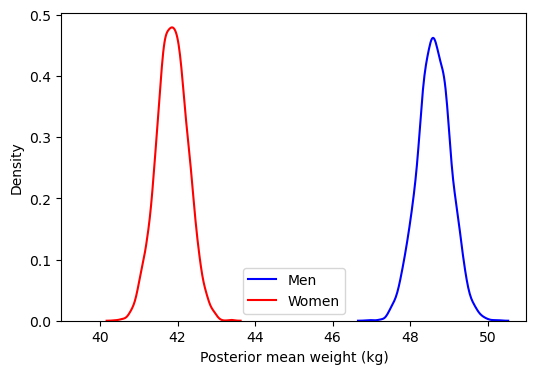

In [41]:
post_trace = trace3.posterior.to_dataframe().reset_index()[["a_dim_0", "a", "sigma"]]
trace_women = post_trace.loc[post_trace["a_dim_0"] == 0]
trace_men = post_trace.loc[post_trace["a_dim_0"] == 1]

plt.figure(figsize=(6, 4))

# A kernel density estimate (KDE) plot is a method for visualizing 
# the distribution of observations in a dataset, analogous to a histogram. 
# KDE represents the data using a continuous probability density curve in one or more dimensions.
sns.kdeplot(data=post_trace, x='a', hue="a_dim_0", palette=["red", "blue"])

plt.xlim(39, 51)
plt.xlabel('Posterior mean weight (kg)')
plt.ylabel('Density')
plt.legend(labels=["Men", "Women"])
plt.show()

<img src="images/image15.jpeg" width="600" height="400" />

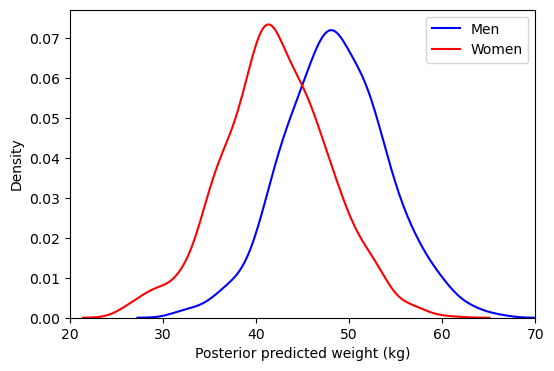

In [42]:
# Generate posterior weight distributions
sz = 1000
W1 = np.random.normal(loc=trace_men["a"][:sz], scale=trace_men["sigma"][:sz], size=sz)
W2 = np.random.normal(loc=trace_women["a"][:sz], scale=trace_women["sigma"][:sz], size=sz)

plt.figure(figsize=(6, 4))

sns.kdeplot(data=W1, color="blue")
sns.kdeplot(data=W2, color="red")

plt.xlim(20, 70)
plt.xlabel('Posterior predicted weight (kg)')
plt.ylabel('Density')
plt.legend(labels=["Men", "Women"])
plt.show()

<img src="images/image18.jpeg" width="600" height="400" />

<Figure size 600x400 with 0 Axes>

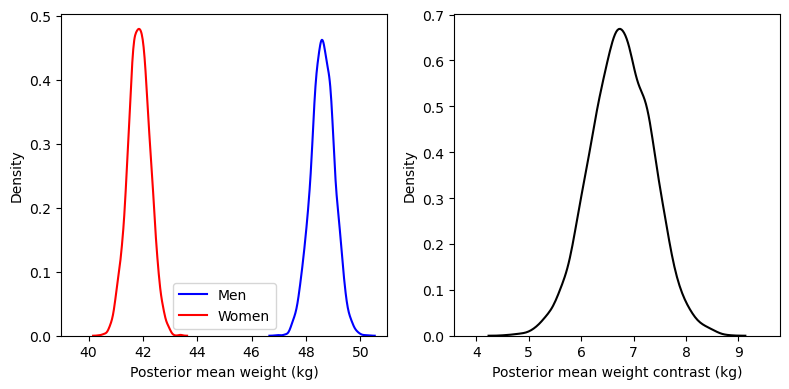

In [43]:
post_trace = trace3.posterior.to_dataframe().reset_index()[["a_dim_0", "a", "sigma"]]
trace_women = post_trace.loc[post_trace["a_dim_0"] == 0]
trace_men = post_trace.loc[post_trace["a_dim_0"] == 1]
trace_diff = trace_men["a"].values - trace_women["a"].values
plt.figure(figsize=(6, 4))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(data=post_trace, x='a', hue="a_dim_0", palette=["red", "blue"], ax=axs[0])
axs[0].set_xlim(39, 51)
axs[0].set_xlabel('Posterior mean weight (kg)')
axs[0].set_ylabel('Density')
axs[0].legend(labels=["Men", "Women"])

sns.kdeplot(data=trace_diff, color="black", ax=axs[1])
axs[1].set_xlim(trace_diff.min()-1, trace_diff.max() + 1)
axs[1].set_xlabel('Posterior mean weight contrast (kg)')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

<img src="images/image19.jpeg" width="600" height="400" />

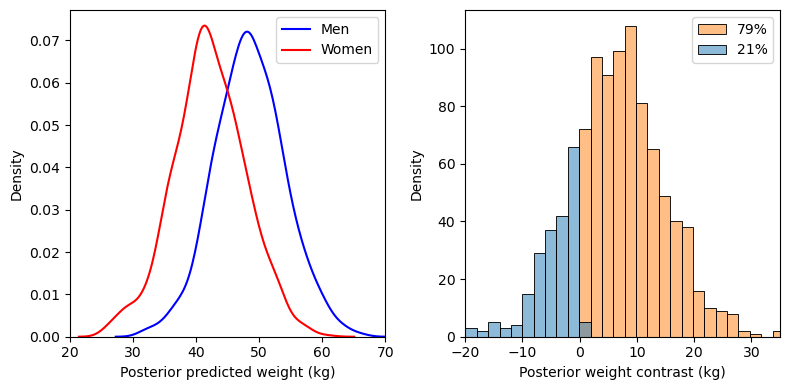

In [44]:
W_diff_df = pd.DataFrame({"W_diff": W1-W2, "W>0": ((W1-W2) > 0).astype(int)}, index=range(len(W1)))

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.kdeplot(data=W1, color="blue", ax=axs[0])
sns.kdeplot(data=W2, color="red", ax=axs[0])
axs[0].set_xlim(20, 70)
axs[0].set_xlabel('Posterior predicted weight (kg)')
axs[0].set_ylabel('Density')
axs[0].legend(labels=["Men", "Women"])

sns.histplot(data=W_diff_df, x="W_diff", hue="W>0", ax=axs[1])
axs[1].set_xlim(-20, 35)
axs[1].set_xlabel('Posterior weight contrast (kg)')
axs[1].set_ylabel('Density')

pct = round((W_diff_df["W>0"].sum() / len(W_diff_df)) * 100)
axs[1].legend([f"{pct}%", f"{100 - pct}%"])

plt.tight_layout()
plt.show()

#### In 82% of times if we randomly choose a man and woman from this population, the man would weight more than the woman. And in 18% the women would weight more.

<img src="images/image21.jpeg" width="600" height="400" /> <img src="images/image22.jpeg" width="600" height="400" /> 

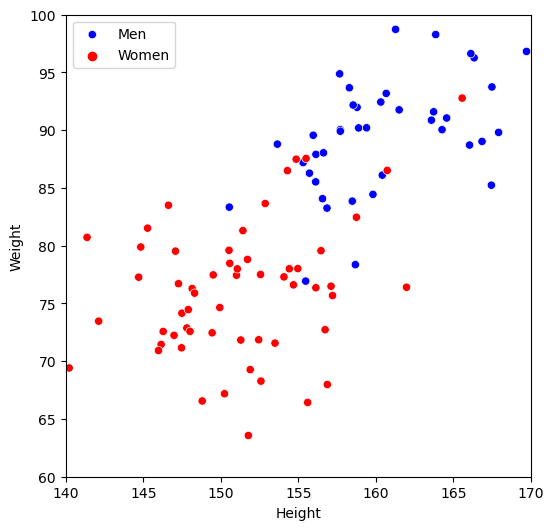

In [45]:
sex = np.random.choice([1, 2], size=100, p=[0.5, 0.5])

# Extract the parameters for intercepts and slopes
b = np.array([0.5, 0.5])
a = np.array([0, 10])

# Simulate the data
sim_data = sim_HW(sex, b, a)

plt.figure(figsize=(6, 6))

sns.scatterplot(data=sim_data, x="Height", y='Weight', hue="Sex", palette=["red", "blue"])
plt.xlim(140, 170)
plt.ylim(60, 100)
plt.legend(labels=["Men", "Women"])
plt.show()

 <img src="images/image27.jpeg" width="800" height="400" />

In [46]:
howell_data.head()

,height,weight,age,sex
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [47]:
sub_data = howell_data.loc[howell_data["age"] >= 18].copy()

W = sub_data["weight"].values
H = sub_data["height"].values
S = sub_data["sex"].values + 1
Hbar = sub_data["height"].mean()

# Define the model
with pm.Model() as model:
    # Priors for the coefficients
    a = pm.Normal('a', mu=60, sigma=10, shape=2)  # a[S]
    b = pm.Normal('b', mu=0, sigma=1, shape=2)  # b[S]
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # Expected value
    mu = a[S-1] + b[S-1] * (H - Hbar)
    
    # Likelihood
    W_obs = pm.Normal('W_obs', mu=mu, sigma=sigma, observed=W)
    
    trace4 = pm.sample(return_inferencedata=True, nuts_sampler="numpyro")

pm.summary(trace4).round(2)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],45.17,0.45,44.30,46.02,0.01,0.01,2725.0,2896.0,1.0
a[1],45.09,0.46,44.25,45.97,0.01,0.01,3060.0,2813.0,1.0
b[0],0.66,0.06,0.54,0.77,0.00,0.00,2921.0,2597.0,1.0
b[1],0.61,0.06,0.51,0.72,0.00,0.00,2940.0,2946.0,1.0
sigma,4.26,0.16,3.98,4.57,0.00,0.00,3815.0,2495.0,1.0


In [48]:
summary4 = pm.summary(trace4).round(2)

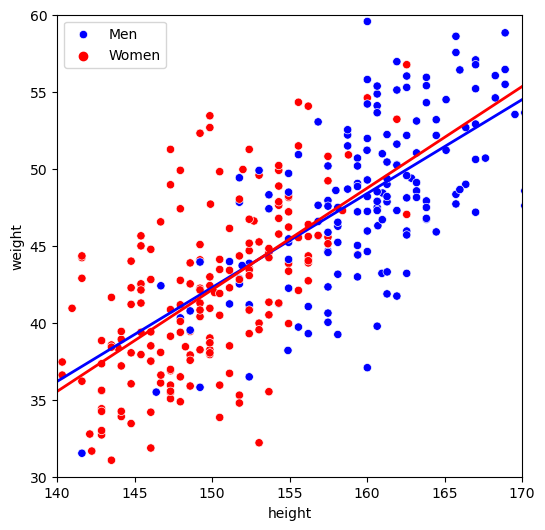

In [49]:
plt.figure(figsize=(6, 6))

sns.scatterplot(data=sub_data, x="height", y='weight', hue="sex", palette=["red", "blue"])
plt.xlim(140, 170)
plt.ylim(30, 60)
plt.legend(labels=["Men", "Women"])

a_women = summary4["mean"]["a[0]"]
a_men = summary4["mean"]["a[1]"]
b_women = summary4["mean"]["b[0]"]
b_men = summary4["mean"]["b[1]"]

height_range = np.linspace(140, 170, 100)
y_values_men = b_men * (height_range - Hbar)+ a_men
y_values_women = b_women * (height_range - Hbar) + a_women

plt.plot(height_range, y_values_men, color='blue', label='Line for Men', linewidth=2)
plt.plot(height_range, y_values_women, color='red', label='Line for Women', linewidth=2)

plt.show()

<img src="images/image29.jpeg" width="800" height="500" />

In [50]:
height_range = np.linspace(130, 190, 50)

# Extract samples
a_samples = trace4.posterior["a"].stack(samples=("chain", "a_dim_0")).values
b_samples = trace4.posterior["b"].stack(samples=("chain", "b_dim_0")).values

# Calculate predictions for females and males
muF_samples = a_samples[:, 0][:, np.newaxis] + b_samples[:, 0][:, np.newaxis] * (height_range - Hbar)
muM_samples = a_samples[:, 1][:, np.newaxis] + b_samples[:, 1][:, np.newaxis] * (height_range - Hbar)

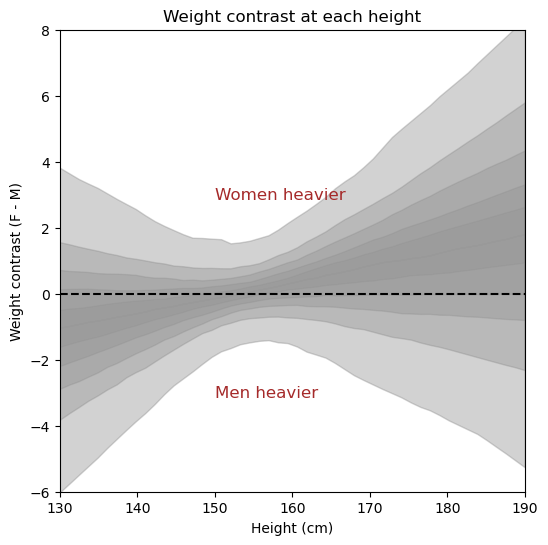

In [51]:
plt.figure(figsize=(6, 6))

# Contrast calculation
mu_contrast_samples = muF_samples - muM_samples

# Plotting the contrast with multiple intervals
percentiles = [50, 60, 70, 80, 90, 99]
for p in percentiles:
    lower_bound = np.percentile(mu_contrast_samples, 100-p, axis=0)
    upper_bound = np.percentile(mu_contrast_samples, p, axis=0)
    plt.fill_between(height_range, lower_bound, upper_bound, color='gray', alpha=0.1 + 0.05 * percentiles.index(p))

plt.axhline(0, color='black', linestyle='--')
plt.text(150, 3, 'Women heavier', color='brown', fontsize=12, ha='left', va='center')
plt.text(150, -3, 'Men heavier', color='brown', fontsize=12, ha='left', va='center')

plt.xlim(130, 190)
plt.ylim(-6, 8)
plt.xlabel('Height (cm)')
plt.ylabel('Weight contrast (F - M)')
plt.title('Weight contrast at each height')

plt.show()

### Interpretation:
##### We found that, on average, men weigh more than women. However, upon controlling for height we observed that this weight difference largely diminishes. This indicates that the observed weight disparity between men and women can be primarily attributed to differences in height. Interestingly, as height increases, women tend to surpass men slightly in average height. So, we can conclude that **almost all of the causal effect of sex is through height.**